In this workbook, I will develop a model to predict claim occurrance using automobile insurance dataset.
To achieve this, I am going to clean and explore the data, conduct statistical analysis and create a logistics regression model.
This dataset comes from the book: "Generalized Linear Models for Insurance Data".

# Import basic libraries

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load data and quick look into dataset

In [2]:
# read excel workbook
xl = pd.read_excel('data.xls', sheetname=None)
# print existing worksheets
print(xl.keys())
# investigate 5 top rows to get an intuitation about the data
xl['claims'].head()

odict_keys(['claims'])


,ID,KIDSDRIV,PLCYDATE,TRAVTIME,CAR_USE,POLICYNO,BLUEBOOK,INITDATE,RETAINED,NPOLICY,...,INCOME,GENDER,MARRIED,PARENT1,JOBCLASS,MAX_EDUC,HOME_VAL,SAMEHOME,DENSITY,YEARQTR
0,100058542,0,17mars96,17,Private,36292520,$9860,06février90,6,2,...,NaN,M,Yes,No,Clerical,<High School,$123721,7.0,Highly Urban,1996Q1
1,100093408,0,26juillet93,18,Private,31958061,$1500,25aoűt89,4,2,...,$4457,M,No,Yes,Student,High School,$0,1.0,Urban,1993Q3
2,100208113,0,06juin94,47,Commercial,42433312,$30460,07juin90,4,1,...,$102904,M,No,No,NaN,Masters,$0,18.0,Urban,1994Q2
3,100237269,0,19janvier99,31,Private,49896544,$16580,01avril95,4,2,...,$14554,F,Yes,No,Student,High School,$0,8.0,Rural,1999Q1
4,10042968,0,18mai99,14,Commercial,79298192,$23030,19mai95,4,1,...,$99493,F,Yes,No,Blue Collar,High School,$288808,1.0,Urban,1999Q2


In [3]:
# print column names for easy access
print(xl['claims'].columns)

Index(['ID', 'KIDSDRIV', 'PLCYDATE', 'TRAVTIME', 'CAR_USE', 'POLICYNO',
       'BLUEBOOK', 'INITDATE', 'RETAINED', 'NPOLICY', 'CAR_TYPE', 'RED_CAR',
       'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CLM_AMT', 'CLM_DATE',
       'CLM_FLAG', 'BIRTH', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'GENDER',
       'MARRIED', 'PARENT1', 'JOBCLASS', 'MAX_EDUC', 'HOME_VAL', 'SAMEHOME',
       'DENSITY', 'YEARQTR'],
      dtype='object')


In [4]:
# choose features and assign them to variable 'data' as pandas dataframe
data = xl['claims'][['KIDSDRIV', 'TRAVTIME', 'CAR_USE', 'MVR_PTS', 'BLUEBOOK', 'RETAINED', 'NPOLICY', 'CAR_TYPE', 'AGE', 'INCOME', 'GENDER', 'MARRIED', 'MAX_EDUC', 'DENSITY', 'CLM_FREQ']]

Here is the description of chosen variables:

- CLM_FREQ No. of claims in 5 years
- AGE Policyholder age
- BLUEBOOK Blue book value of car
- CAR_TYPE Type of car: sedan, SUV, etc.
- CAR_USE Private or Commercial use
- DENSITY Population Density (rural, urban)
- GENDER Gender
- INCOME Policyholder income
- KIDSDRIVE No. of children that drive
- MARRIED Marital status
- MAX_EDUC Highest education
- MVR_PTS Motor Vehicle Points
- NPOLICY Number of policies
- PLCYDATE Policy Inception Data
- RETAINED Number of years policy renewed
- TRAVTIME Travel time to work

# Data wrangling and exploration 

Let's have another look at our data and see for missing values and type of each feature.

In [5]:
data.head()

,KIDSDRIV,TRAVTIME,CAR_USE,MVR_PTS,BLUEBOOK,RETAINED,NPOLICY,CAR_TYPE,AGE,INCOME,GENDER,MARRIED,MAX_EDUC,DENSITY,CLM_FREQ
0,0,17,Private,0,$9860,6,2,Pickup,41-60,NaN,M,Yes,<High School,Highly Urban,0
1,0,18,Private,4,$1500,4,2,Sedan,25-40,$4457,M,No,High School,Urban,0
2,0,47,Commercial,0,$30460,4,1,Panel Truck,41-60,$102904,M,No,Masters,Urban,2
3,0,31,Private,0,$16580,4,2,SUV,41-60,$14554,F,Yes,High School,Rural,0
4,0,14,Commercial,2,$23030,4,1,Pickup,41-60,$99493,F,Yes,High School,Urban,2


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 15 columns):
KIDSDRIV    10296 non-null int64
TRAVTIME    10296 non-null int64
CAR_USE     10296 non-null object
MVR_PTS     10296 non-null int64
BLUEBOOK    10296 non-null object
RETAINED    10296 non-null int64
NPOLICY     10296 non-null int64
CAR_TYPE    10296 non-null object
AGE         10296 non-null object
INCOME      9727 non-null object
GENDER      10296 non-null object
MARRIED     10296 non-null object
MAX_EDUC    10296 non-null object
DENSITY     10296 non-null object
CLM_FREQ    10296 non-null int64
dtypes: int64(6), object(9)
memory usage: 1.2+ MB


In [7]:
# there is only one column with missing data ("INCOME")
# given relatively low ratio of missing values, I delete all rows containing them
data = data.dropna()

In [8]:
# transform 'object' data type to 'category'

data['CAR_USE'] = data['CAR_USE'].astype('category')
data['CAR_TYPE'] = data['CAR_TYPE'].astype('category')
data['AGE'] = data['AGE'].astype('category')
data['GENDER'] = data['GENDER'].astype('category')
data['MARRIED'] = data['MARRIED'].astype('category')
data['MAX_EDUC'] = data['MAX_EDUC'].astype('category')
data['DENSITY'] = data['DENSITY'].astype('category')
cat_columns = data.select_dtypes(['category']).columns

In [9]:
# remove '$' sign 
data['BLUEBOOK'] = data['BLUEBOOK'].apply(lambda x: re.findall('\d+', x)[0])
data['INCOME'] = data['INCOME'].apply(lambda x: re.findall('\d+', x)[0])
# change datatype to 'integer'
data['BLUEBOOK'] = data['BLUEBOOK'].astype(int)
data['INCOME'] = data['INCOME'].astype(int)

## Data visualization

It's time to visualize our data to find out something new about chosen features. We want to see:
- the distribution of our target,
- interactions between single features and the target,
- correllation heat-map.

0    5942
2    1402
1    1207
3     938
4     217
5      21
Name: CLM_FREQ, dtype: int64


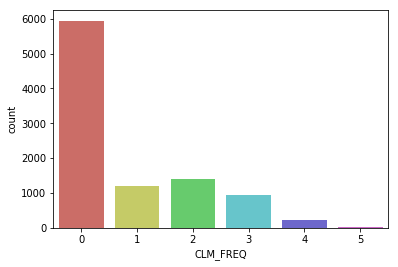

mean = 0.8016860285802405
variance = 1.3368756270955577


In [10]:
print(data['CLM_FREQ'].value_counts())
sns.countplot(x='CLM_FREQ', data=data, palette='hls')
plt.show()
print("mean = " + str(data['CLM_FREQ'].mean()))
print("variance = " + str(data['CLM_FREQ'].var()))

This is a 'skewed right' distribution, where the majority of car users did not raise a claim at all. Given this proportion, it will be more insightful to predict whether a claim occurs or not. Let's change transform our target variable to binary.

In [11]:
# binarize the target
data['CLM_YesNo'] = data.loc[:, 'CLM_FREQ'] > 0
data['CLM_YesNo'] = data.loc[:, 'CLM_YesNo'].astype(int)

In [12]:
# remove the old target
data.drop('CLM_FREQ', axis=1, inplace=True)

Now I want to learn something about categorical features and their influence on dependent variable.

Text(0,0.5,'Claim Yes/No')

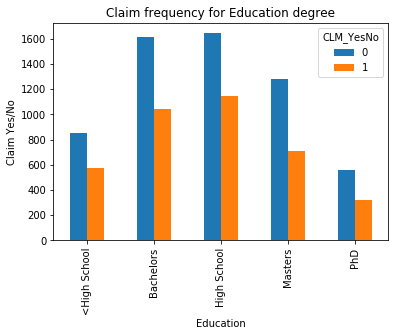

In [13]:
pd.crosstab(data['MAX_EDUC'],data['CLM_YesNo']).plot(kind='bar', stacked=False)
plt.title('Claim frequency for Education degree')
plt.xlabel('Education')
plt.ylabel('Claim Yes/No')

Knowing education degree doesn't help much.

Text(0,0.5,'Claim Yes/No')

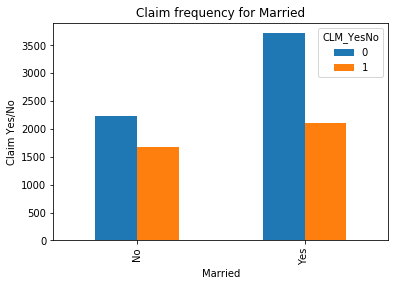

In [14]:
pd.crosstab(data['MARRIED'],data['CLM_YesNo']).plot(kind='bar', stacked=False)
plt.title('Claim frequency for Married')
plt.xlabel('Married')
plt.ylabel('Claim Yes/No')

Singles tend to raise claims more often than married.

Text(0,0.5,'Claim Yes/No')

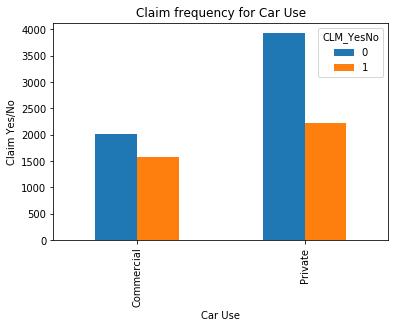

In [15]:
pd.crosstab(data['CAR_USE'],data['CLM_YesNo']).plot(kind='bar', stacked=False)
plt.title('Claim frequency for Car Use')
plt.xlabel('Car Use')
plt.ylabel('Claim Yes/No')

Text(0,0.5,'Claim Yes/No')

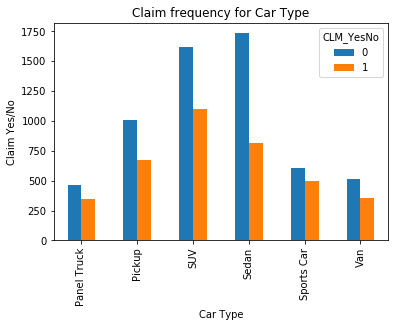

In [16]:
pd.crosstab(data['CAR_TYPE'],data['CLM_YesNo']).plot(kind='bar', stacked=False)
plt.title('Claim frequency for Car Type')
plt.xlabel('Car Type')
plt.ylabel('Claim Yes/No')

Sports car users claim much more often than sedan users.

Text(0,0.5,'Claim Yes/No')

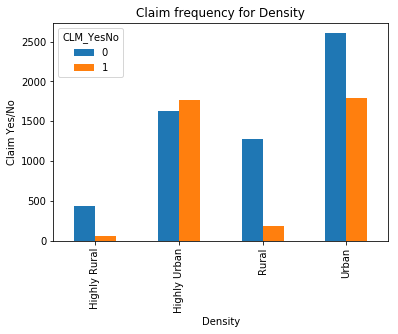

In [17]:
pd.crosstab(data['DENSITY'],data['CLM_YesNo']).plot(kind='bar', stacked=False)
plt.title('Claim frequency for Density')
plt.xlabel('Density')
plt.ylabel('Claim Yes/No')

Density seems to have significant meaning for our prediction. People who live in rural areas hardly ever raise a claim.

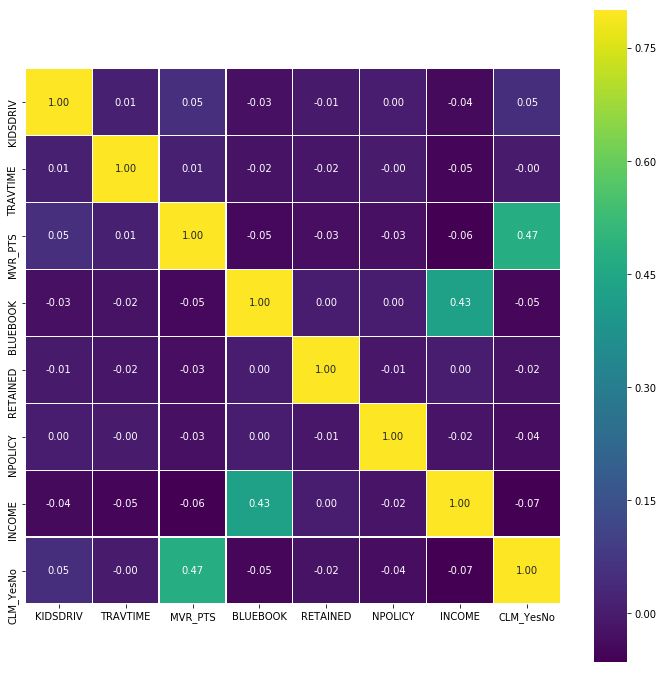

In [18]:
colormap = plt.cm.viridis
cor = data.corr()
#cor = cor.drop(['AGE*GENDER'],axis=1).drop(['AGE*GENDER'],axis=0)
plt.figure(figsize=(12,12))
sns.heatmap(cor,vmax=0.8,cmap=colormap,annot=True,fmt='.2f',square=True,annot_kws={'size':10},linecolor='white',linewidths=0.1)

Note the moderate correllation between following variables:
- Income & Bluebook (R^2 = 0.43)
- MVR_PTS & CLM_YesNo (R^2 = 0.47)

The is no need to drop any more features.

# Create Dummy (one-hot) Variables

I will use a pandas function '.get_dummies' to split all categorical features into separate columns.

In [19]:
data_final = pd.get_dummies(data, drop_first=True)
data_final.columns.values

array(['KIDSDRIV', 'TRAVTIME', 'MVR_PTS', 'BLUEBOOK', 'RETAINED',
       'NPOLICY', 'INCOME', 'CLM_YesNo', 'CAR_USE_Private',
       'CAR_TYPE_Pickup', 'CAR_TYPE_SUV', 'CAR_TYPE_Sedan',
       'CAR_TYPE_Sports Car', 'CAR_TYPE_Van', 'AGE_25-40', 'AGE_41-60',
       'AGE_>60', 'GENDER_M', 'MARRIED_Yes', 'MAX_EDUC_Bachelors',
       'MAX_EDUC_High School', 'MAX_EDUC_Masters', 'MAX_EDUC_PhD',
       'DENSITY_Highly Urban', 'DENSITY_Rural', 'DENSITY_Urban'], dtype=object)

In [20]:
# select features and target and assign them to corresponding variables
y_all = data_final['CLM_YesNo']
X_all = data_final.drop('CLM_YesNo', axis = 1)

# Feature Selection using Recursive Feature Elimination (RFE) & Lasso

Feature selection is a vital step in preparing our data for modelling. We want to feed our model with meaningful features. From the chosen methods, the more accurate one will end up in the final regression.
It's time to import necessary libraries:

In [21]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import RandomizedLasso
from sklearn.linear_model import LogisticRegression

In [22]:
# RFE selection
logreg = LogisticRegression()

rfe = RFE(logreg, 13)
rfe = rfe.fit(X_all, y_all)
print(rfe.support_)
print(rfe.ranking_)

[ True False  True False False False False  True False  True  True  True
 False False  True False  True  True False False  True  True  True False
  True]
[ 1 10  1 11  8  3 12  1  9  1  1  1  6  7  1  2  1  1 13  4  1  1  1  5  1]


In [23]:
# print out column names
X_rfe = X_all[X_all.columns[rfe.support_]]
print (X_rfe.columns)

Index(['KIDSDRIV', 'MVR_PTS', 'CAR_USE_Private', 'CAR_TYPE_SUV',
       'CAR_TYPE_Sedan', 'CAR_TYPE_Sports Car', 'AGE_41-60', 'GENDER_M',
       'MARRIED_Yes', 'MAX_EDUC_Masters', 'MAX_EDUC_PhD',
       'DENSITY_Highly Urban', 'DENSITY_Urban'],
      dtype='object')


In [24]:
# lasso selection 
rlasso = RandomizedLasso(scaling=0.025)
rlasso.fit(X_all, y_all)

print(rlasso.scores_)

C:\Users\Adrian\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


[ 0.51   0.4    1.     0.455  0.495  0.475  0.49   0.49   0.47   0.525
  0.505  0.52   0.455  0.36   0.435  0.44   0.49   0.46   0.37   0.44   0.43
  0.47   0.725  0.755  0.585]


In [25]:
# print out column names
X_lasso = X_all[X_all.columns[rlasso.scores_ >= 0.45]]
print(X_lasso.columns)

Index(['KIDSDRIV', 'MVR_PTS', 'BLUEBOOK', 'RETAINED', 'NPOLICY', 'INCOME',
       'CAR_USE_Private', 'CAR_TYPE_Pickup', 'CAR_TYPE_SUV', 'CAR_TYPE_Sedan',
       'CAR_TYPE_Sports Car', 'CAR_TYPE_Van', 'GENDER_M', 'MARRIED_Yes',
       'MAX_EDUC_PhD', 'DENSITY_Highly Urban', 'DENSITY_Rural',
       'DENSITY_Urban'],
      dtype='object')


In [26]:
# rename our target vector
y = y_all

# General Linear Models

Let's compare our feature selections on two distributions: Poisson and Negative Binomial.
For this purpose, I am using 'statsmodels' library.

In [27]:
import statsmodels.api as sm

C:\Users\Adrian\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [28]:
# model Poisson with RFE features
glm_poisson1 = sm.GLM(y, X_rfe, family=sm.families.Poisson())
res = glm_poisson1.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              CLM_YesNo   No. Observations:                 9727
Model:                            GLM   Df Residuals:                     9714
Model Family:                 Poisson   Df Model:                           12
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -7048.0
Date:                Fri, 08 Dec 2017   Deviance:                       6526.1
Time:                        17:41:00   Pearson chi2:                 5.81e+03
No. Iterations:                     5                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
KIDSDRIV                -0.0087      0.029     -0.294      0.769      -0.066       0.049
MVR_PTS               

In [29]:
# model Poisson with Lasso features
glm_poisson1 = sm.GLM(y, X_lasso, family=sm.families.Poisson())
res = glm_poisson1.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              CLM_YesNo   No. Observations:                 9727
Model:                            GLM   Df Residuals:                     9709
Model Family:                 Poisson   Df Model:                           17
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -6646.6
Date:                Fri, 08 Dec 2017   Deviance:                       5723.1
Time:                        17:41:00   Pearson chi2:                 5.58e+03
No. Iterations:                     5                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
KIDSDRIV                 0.0618      0.029      2.109      0.035       0.004       0.119
MVR_PTS               

In [30]:
# model Negative binomial with RFE features
glm_binom1 = sm.GLM(y, X_rfe, family=sm.families.NegativeBinomial())
res = glm_binom1.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              CLM_YesNo   No. Observations:                 9727
Model:                            GLM   Df Residuals:                     9714
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    log   Scale:                  0.450673176687
Method:                          IRLS   Log-Likelihood:                -7757.3
Date:                Fri, 08 Dec 2017   Deviance:                       5020.4
Time:                        17:41:00   Pearson chi2:                 4.38e+03
No. Iterations:                     8                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
KIDSDRIV                 0.0074      0.024      0.305      0.760      -0.040       0.055
MVR_PTS               

In [31]:
# model Negative binomial with Lasso features
glm_binom1 = sm.GLM(y, X_lasso, family=sm.families.NegativeBinomial())
res = glm_binom1.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              CLM_YesNo   No. Observations:                 9727
Model:                            GLM   Df Residuals:                     9709
Model Family:        NegativeBinomial   Df Model:                           17
Link Function:                    log   Scale:                   0.45486988662
Method:                          IRLS   Log-Likelihood:                -7476.5
Date:                Fri, 08 Dec 2017   Deviance:                       4458.7
Time:                        17:41:00   Pearson chi2:                 4.42e+03
No. Iterations:                     7                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
KIDSDRIV                 0.0849      0.025      3.430      0.001       0.036       0.133
MVR_PTS               

The main takeaway from these reports is, that in both cases the features selected by Lasso method seem to perform better (coefficients are better matched). I inference this by comparing Log-Likelihood parameters. A side note is that in our example Poisson model performs better than the Negative binomial model. 

In order to measure the accuracy of my work and make it interpretable, I will move forward to regular Logistics Regression model. But prior to that, let's take a look at the baseline model, hence the simplest possible model assuming no claims at all.

In [32]:
# divide 0 claims by all observations
bas = 5942/len(y)
print ("Baseline accuracy: " + str(bas))

Baseline accuracy: 0.6108769404749665


In [33]:
# choose features selected by Lasso method
X = X_lasso

In [34]:
# split the data
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)

# train the model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\Adrian\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
# predict and check accuracy
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.73


In [36]:
# check the first 5 predictions
y_pred[:5]

array([1, 0, 1, 0, 1])

In [37]:
# generate class probabilities
probs = logreg.predict_proba(X_test)
print (probs[:5])

[[ 0.06834711  0.93165289]
 [ 0.85911005  0.14088995]
 [ 0.43202189  0.56797811]
 [ 0.64013237  0.35986763]
 [ 0.12859449  0.87140551]]


# Confusion Matrix

Although, general accuracy is very important in any classification method, investigating Confusion Matrix will lead us to even more insightful conclusions.

In [38]:
# create simple confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1299  232]
 [ 416  485]]


TP: 1299 (accurately predicted no-claim) FN: 232 (falsely predicted claim)
FP: 416 (falsely predicted no-claim) TN: 485 (accurately predicted claim)

In [40]:
# precision & recall
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.76      0.85      0.80      1531
          1       0.68      0.54      0.60       901

avg / total       0.73      0.73      0.73      2432



In [41]:
# precision -> the ratio of people who did not raise a claim out of all people who we predicted that will do so 

# recall (sensitivity) -> out of all people, who did not raise a claim, how successful we were in predicting so? 

# f1-score -> weighted average of precision and recall

# ROC CURVE

The ROC curve is a fundamental tool for test evaluation and is complementary to sensitivity/specificity report. It shows true positive rate (sensitivity) vs false positive rate (100 - specificity) for different cut-off points.

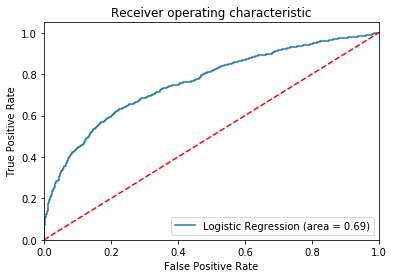

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

At this point I finish my analysis. I hope you enjoyed going through this notebook.